In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/diabetes/diabetes.csv")
data.head()
data.shape

(253680, 22)

In [4]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data = data[:70000]

In [5]:
target = 'Diabetes_binary'

In [6]:
X = data.drop(columns=[target])
y = data[target]

In [7]:
#model_ctgan = CTGANSynthesizer(epochs=20)
model_ctgan = DPCTGANSynthesizer(verbose=True)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data)

Init CTGAN with differential privacy.  Target epsilon: 3
Epoch 1, Loss G:  0.7801, Loss D: -0.1030, Epsilon: 1.5110
Epoch 2, Loss G: -0.1117, Loss D: -0.2971, Epsilon: 1.5828
Epoch 3, Loss G: -0.0116, Loss D: -0.1671, Epsilon: 1.6547
Epoch 4, Loss G:  0.5724, Loss D: -0.0886, Epsilon: 1.7266
Epoch 5, Loss G:  0.5040, Loss D:  0.0148, Epsilon: 1.7984
Epoch 6, Loss G:  0.9313, Loss D: -0.1658, Epsilon: 1.8703
Epoch 7, Loss G:  0.5079, Loss D: -0.1504, Epsilon: 1.9422
Epoch 8, Loss G:  0.7860, Loss D: -0.1588, Epsilon: 2.0140
Epoch 9, Loss G:  1.1279, Loss D:  0.2707, Epsilon: 2.0859
Epoch 10, Loss G:  1.0770, Loss D:  0.2553, Epsilon: 2.1578
Epoch 11, Loss G:  0.3819, Loss D:  0.2019, Epsilon: 2.2296
Epoch 12, Loss G:  0.8558, Loss D: -0.1756, Epsilon: 2.3015
Epoch 13, Loss G:  0.3008, Loss D: -0.1893, Epsilon: 2.3734
Epoch 14, Loss G:  0.6865, Loss D: -0.0611, Epsilon: 2.4423
Epoch 15, Loss G:  0.7361, Loss D: -0.1484, Epsilon: 2.4993
Epoch 16, Loss G:  1.1835, Loss D: -0.2065, Epsilon:

In [8]:
from utils.utils import save_models
save_models(model_ctgan, 'dpctgan3', 'diabetes')

In [9]:
from utils.utils import load_models
model_ctgan = load_models('dpctgan3', 'diabetes')

In [10]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [11]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [12]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.15249756]


## Fidelity

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

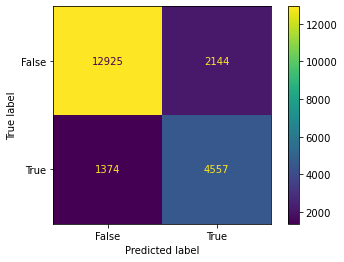

In [14]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [15]:
percentage, class1_ratio, class2_ratio = eval_fidelity(rr_pred, fr_pred)

In [16]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.7688571428571429
Accuracy of synthetic data:  0.7256190476190476


In [17]:
print(class1_ratio, class2_ratio)

0.7860487745545217 0.5643343653250774


## Final plot

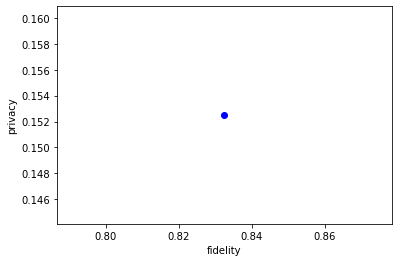

0.8324761904761905 [0.15249756]


In [18]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)